In [1]:
import sys 
sys.path.append('../scripts/')
from qmdp import *
from sensor_reset_mcl import *

In [2]:
class PfcAgent(QmdpAgent):   ###pfc3 （3, 6, 8−11行目）
    def __init__(self, time_interval, estimator, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, magnitude=2):  #magnitudeを追加
        super().__init__(time_interval, estimator, goal, puddles, sampling_num, widths, puddle_coef, lowerleft, upperright)
        
        self.magnitude = magnitude #追加
        self.dp.value_function = self.init_value()
        
    def init_value(self):
        tmp = np.zeros(self.dp.index_nums)
        for line in open("../data/value_for_pfc.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = float(d[3])
            
        return tmp
            
    def evaluation(self, action, indexes): #メソッドを追加
        v = self.dp.value_function                                                                                 #名前が長いのでvという別名をつける
        vs = [abs(v[i]) if abs(v[i]) > 0.0 else 1e-10 for i in indexes]                        #PFCの式の分母
        qs = [self.dp.action_value(action, i, out_penalty=False) for i in indexes]   #QMDPの値
        
        return sum([q/(v**self.magnitude) for (v,q) in zip(vs, qs)])  #式の上ではlen(indexes)で割る必要があるが省略
        
    def policy(self, pose, goal=None):
        for p in self.estimator.particles:
            if self.goal.inside(p.pose): p.weight *= 1e-10
        self.estimator.resampling()
        
        return  super().policy(pose, goal)

<IPython.core.display.Javascript object>


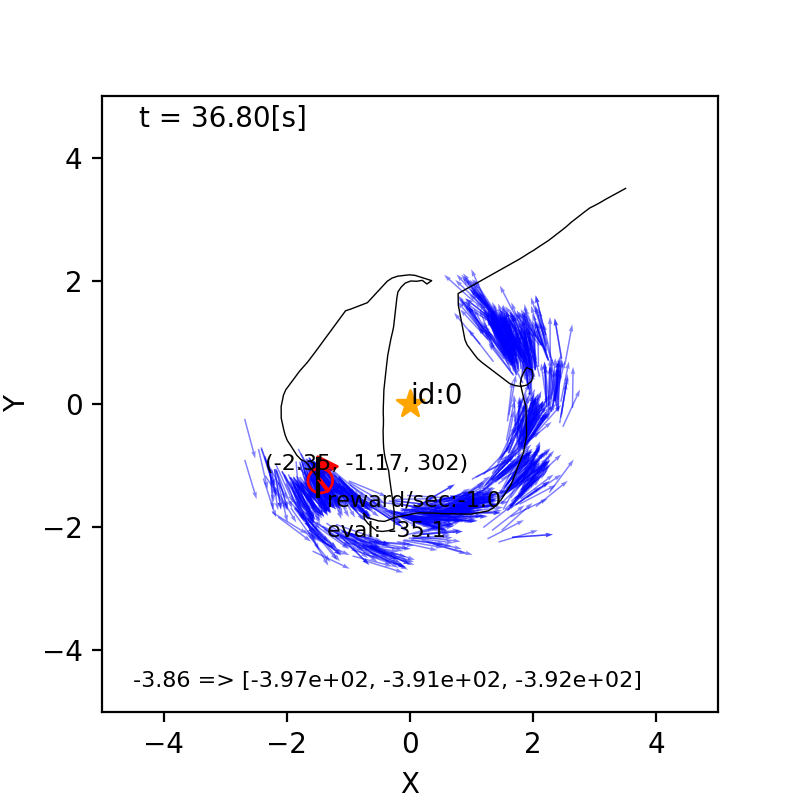

In [3]:
def trial(animation):
    time_interval = 0.1
    world = PuddleWorld(300, time_interval, debug=not animation) 

    ##ランドマークの追加（1個だけ）##
    m = Map()
    m.append_landmark(Landmark(0,0))
    world.append(m) 
    
    ##ゴール##
    goal = Goal(-1.5,-1.5)
    world.append(goal)
    
    ##ロボットを作る##
    pf = ResetMcl(m, [-10, -10, 0], 1000)              #誘拐状態から始める（すぐセンサリセットされる）
    a = PfcAgent(time_interval, pf, goal, [])           #水たまりはナシに。空のリストを渡す
    r = Robot(np.array([3.5, 3.5, np.pi]).T, sensor=Camera(m), agent=a, color="red")

    world.append(r)
    world.draw()
#    world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=1)
trial(True)